In [1]:
import tensorflow as tf
from tensorflow import keras
import py_files
from py_files import load_data, const, bird_info
import warnings
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import  math
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

2021-12-16 10:33:30.099733: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-16 10:33:30.099761: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# !unzip drive/MyDrive/img.zip

In [4]:
# Load data from pre-processed numpy arrays
def load_data():
    # data = np.load('np_arrays/images_and_labels.npy', allow_pickle=True)
    # data_test = np.load('drive/MyDrive/images_and_labels_test.npy', allow_pickle=True)
    # names=np.load('drive/MyDrive/name.npy')
    # names_test=np.load('drive/MyDrive/name.npy')
    data = np.load('np_arrays/images_and_labels.npy', allow_pickle=True)
    data_test = np.load('np_arrays/images_and_labels_test.npy', allow_pickle=True)
    names=np.load('np_arrays/name.npy')
    names_test=np.load('np_arrays/name_test.npy')
    return data, data_test, names, names_test

In [5]:
data, data_test, names, names_test = load_data()

In [6]:
pd_data=pd.DataFrame(data, columns=['Images', 'Labels', 'Image_Quality'])

In [7]:
labels_value, labels_counts = np.unique(data[:,1], return_counts=True)
image_quality_values, image_quality_counts = np.unique(data[:,2], return_counts=True)

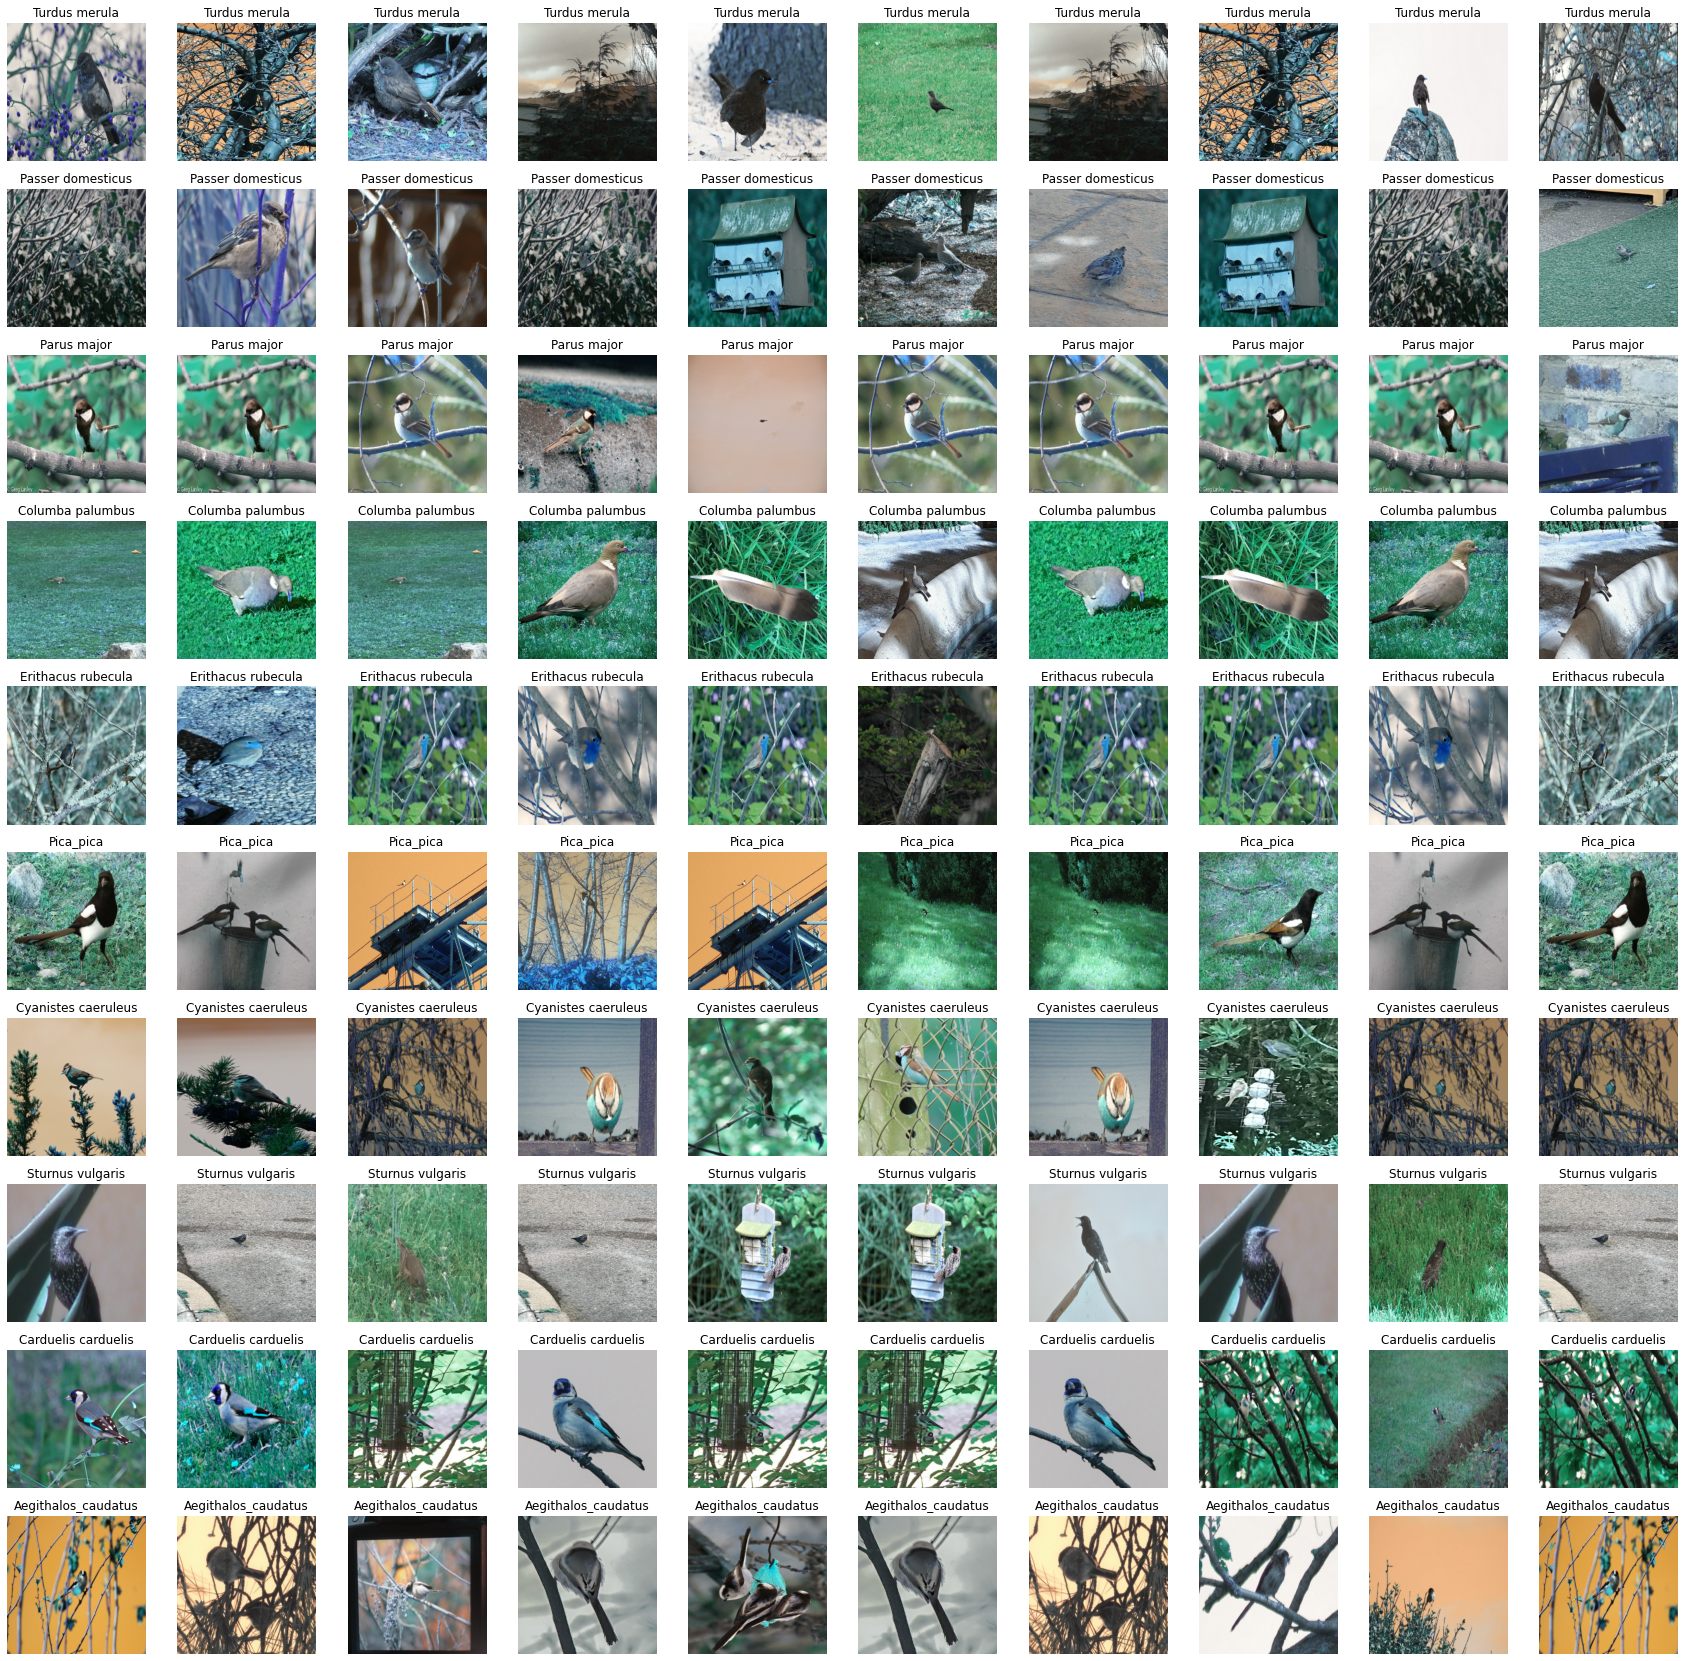

In [8]:
bird_info.visualise_10_10_images(data_test, labels_value)

In [34]:
def count_bar_plot(data):
    plt.style.use('ggplot')
    fig, ax = plt.subplots(figsize=(12,7))
    # Set tick font size
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(13)

    ax.bar(np.arange(10), data, align='center', color='darkblue')
    ax.set_xticks(np.arange(10))
    ax.set_xticklabels(const.COMMON_NAMES, rotation=90)
    ax.set_ylabel('Count')
    ax.set_title('Count of Each Bird Species')
    plt.show()

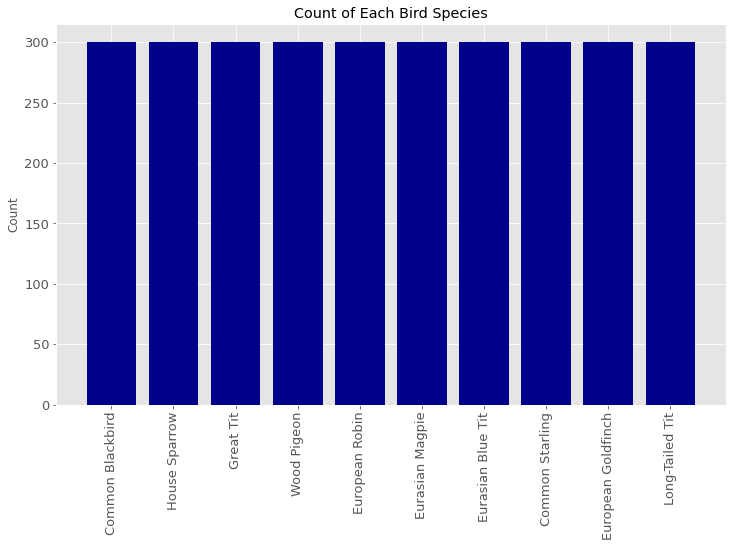

In [35]:
count_bar_plot(labels_counts)

In [ ]:
aggs=pd_data.groupby(['Labels', 'Image_Quality'])['Labels'].count().unstack()
aggs.columns=['Excellent','Good','Average','Poor','Very Poor']
aggs.index=const.COMMON_NAMES
aggs

In [ ]:
fig, ax = plt.subplots(figsize=(12,12))

image_quality_l=aggs.columns.tolist()
labels_l=aggs.index.tolist()

y1=aggs['Excellent']
y2=aggs['Good']
y3=aggs['Average']
y4=aggs['Poor']
y5=aggs['Very Poor']

very_poor=ax.bar(labels_l, y5, label=image_quality_l[4])
poor=ax.bar(labels_l, y4, bottom=y5, label=image_quality_l[3])
average=ax.bar(labels_l, y3, bottom=y4+y5, label=image_quality_l[2])
good=ax.bar(labels_l, y2, bottom=y3+y4+y5, label=image_quality_l[1])
excellent=ax.bar(labels_l, y1, bottom=y2+y3+y4+y5, label=image_quality_l[0])

# Set tick font size
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(13)

ax.set_xticklabels(labels_l, rotation=90)
ax.set_ylabel('Count')
ax.set_title('Image Quality for each class')
ax.legend(handles=[excellent, good, average, poor, very_poor], loc=0)

plt.show()


In [ ]:
def filter_data_by_image_quality(quality_boundary):
    df=pd_data[pd_data['Image_Quality']<=quality_boundary]
    return df

In [ ]:
filtered_df=filter_data_by_image_quality(2)

In [ ]:
filtered_df['Labels'].loc[3]

In [ ]:
def resize_images(df):
    resize_images=[]
    for i in df.index:
        resize_images.append(cv2.resize(df['Images'].loc[i], (256,256)))
    return resize_images

In [ ]:
filtered_df['Images'] = resize_images(filtered_df)

In [ ]:
bird_info.visualise_10_10_images(np.array(filtered_df), labels_value)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation, Flatten, Dense, Dropout, Rescaling

def alexNet():
    #Instantiation
    AlexNet = keras.Sequential()

    AlexNet.add(layers.RandomFlip("horizontal"))
    AlexNet.add(layers.RandomFlip("horizontal_and_vertical"))
    AlexNet.add(layers.RandomRotation(0.1))
    AlexNet.add(layers.RandomRotation(0.3))
    
    AlexNet.add(layers.Rescaling(1./255))

    #1st Convolutional Layer - 96 filters instead of two parllel 48 filters
    AlexNet.add(Conv2D(filters=96, input_shape=(256, 256,3), kernel_size=(3,3), strides=(4,4), padding='same'))
    AlexNet.add(BatchNormalization())
    AlexNet.add(Activation('relu'))
    AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

    #2nd Convolutional Layer
    AlexNet.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1,1), padding='same'))
    AlexNet.add(BatchNormalization())
    AlexNet.add(Activation('relu'))
    AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

    #3rd Convolutional Layer
    AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
    AlexNet.add(BatchNormalization())
    AlexNet.add(Activation('relu'))

    #4th Convolutional Layer
    AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
    AlexNet.add(BatchNormalization())
    AlexNet.add(Activation('relu'))

    #5th Convolutional Layer
    AlexNet.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
    AlexNet.add(BatchNormalization())
    AlexNet.add(Activation('relu'))
    AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

    #Passing it to a Fully Connected layer
    AlexNet.add(Flatten())
    # 1st Fully Connected Layer
    AlexNet.add(Dense(4096, input_shape=(32,32,3,)))
    AlexNet.add(BatchNormalization())
    AlexNet.add(Activation('relu'))
    # Add Dropout to prevent overfitting
    AlexNet.add(Dropout(0.4))

    #2nd Fully Connected Layer
    AlexNet.add(Dense(4096))
    AlexNet.add(BatchNormalization())
    AlexNet.add(Activation('relu'))
    #Add Dropout
    AlexNet.add(Dropout(0.4))

    #3rd Fully Connected Layer
    AlexNet.add(Dense(1000))
    AlexNet.add(BatchNormalization())
    AlexNet.add(Activation('relu'))
    #Add Dropout
    AlexNet.add(Dropout(0.4))

    #Output Layer
    AlexNet.add(Dense(10))
    AlexNet.add(BatchNormalization())
    AlexNet.add(Activation('softmax'))
    
    return AlexNet


In [ ]:
m = alexNet()

In [ ]:
m.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

In [ ]:

labels_np=np.array(filtered_df['Labels'].tolist())
images_np=np.array(filtered_df['Images'].tolist())

In [ ]:
X_train, X_test, Y_train, Y_test=train_test_split(images_np, labels_np,test_size=0.2, random_state=133)

In [ ]:
X_train=np.array(X_train).astype('float32')
Y_train=np.array(Y_train).astype('float32')
X_test=np.array(X_test).astype('float32')
Y_test=np.array(Y_test).astype('float32')

In [ ]:
Y_train = keras.utils.to_categorical(Y_train, num_classes=10)
Y_test = keras.utils.to_categorical(Y_test, num_classes=10)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
modelCheckpoint=ModelCheckpoint('alex_net1', save_weights_only=True, save_best_only=True)

In [ ]:
Y_train.shape

In [ ]:
history=m.fit(X_train, Y_train, validation_data=(X_test, Y_test),epochs=50, verbose=1)

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)

In [ ]:
X_val = np.array(data_test[:,0].tolist())
Y_val = np.array(data_test[:,1].tolist())
Y_val = keras.utils.to_categorical(Y_val, num_classes=10)

In [ ]:
X_val.shape


In [ ]:
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val))

In [ ]:
m.evaluate(X_val, Y_val)

In [ ]:
preds = m.predict(X_val)

In [ ]:
max_val_per_row=np.amax(preds, axis=1)
max_val_per_row

In [ ]:
max_where=[]
for index, max_row in enumerate(max_val_per_row):
  a = np.where(preds[index]==max_row)
  max_where.append(int(a[0]))

In [ ]:
from sklearn.metrics import confusion_matrix 
import seaborn as sns
results = confusion_matrix(data_test[:,1].tolist(), max_where)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(results, annot=True, fmt='d')


In [ ]:
plt.figure(figsize=(30, 30))
for index, image_l in enumerate(X_val):
  ax = plt.subplot(10, 10, index + 1)
  plt.imshow(X_val[index])
  plt.title(str(max_where[index]) +  "===" + str(data_test[index,1]))
  plt.axis('off')